In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from src.ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-inception-v2-reduced-rgb-first-normal"


/home/jelinek/recetox/src/notebooks/model_heaven


In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256

    @staticmethod
    def get_inception_module_dim_reduction(prev_layer, filters_1, filters_2):
        c11 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        c12 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(prev_layer)
        c13 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        p1 = keras.layers.MaxPooling2D(padding='same', strides=(1,1), pool_size=(3,3))(prev_layer)

        c21 = keras.layers.Conv2D(filters=filters_2, kernel_size=(3,3), padding='same')(c12)
        c22 = keras.layers.Conv2D(filters=filters_2, kernel_size=(5,5), padding='same')(c13)
        c23 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(p1)

        output_layer = concatenate([c11, c21, c22, c23], axis=-1)

        return output_layer


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same')(inputs)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=8,
                                                filters_2=8)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=16,
                                                filters_2=16)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=32,
                                                filters_2=32)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=64,
                                                filters_2=64)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=128,
                                                filters_2=128)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=12, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=150,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

Model: "MySimpleCnnFewerLayers"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 1216        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          max_pooling2d[0][0]              
_____________________________________________________________________________

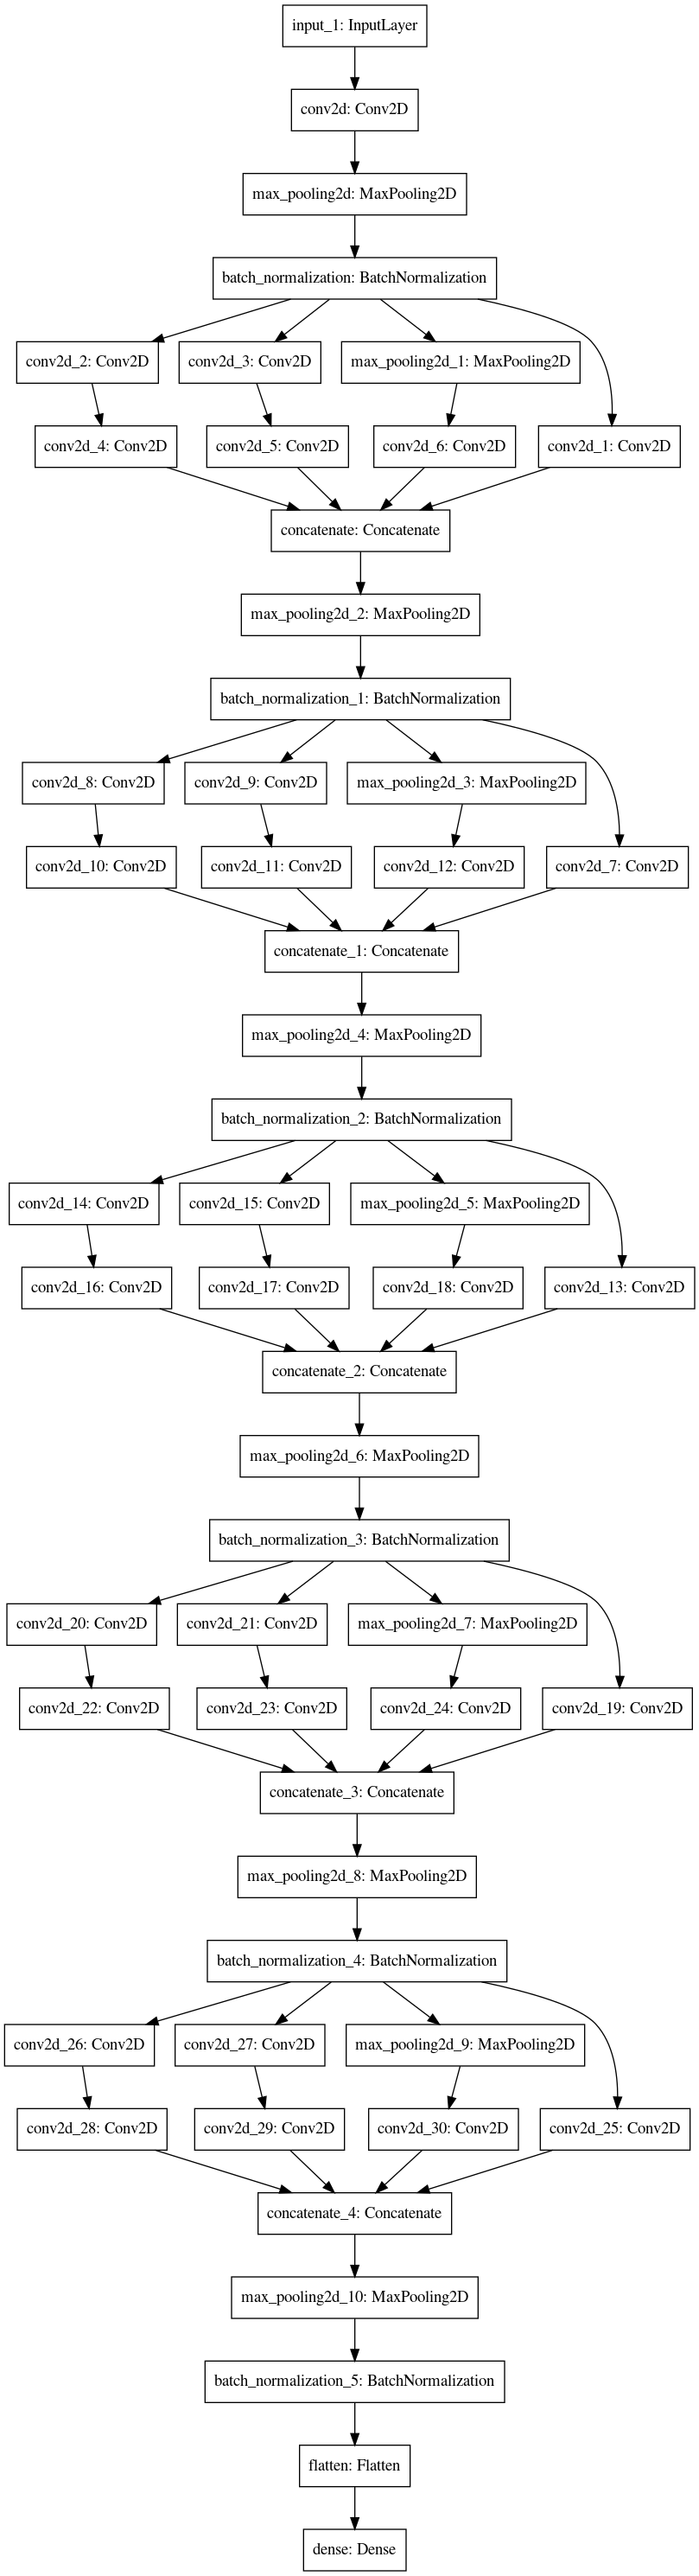

In [3]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                                      valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

keras.utils.plot_model(pipeline.model, 'model-figs/' + name + '.png')

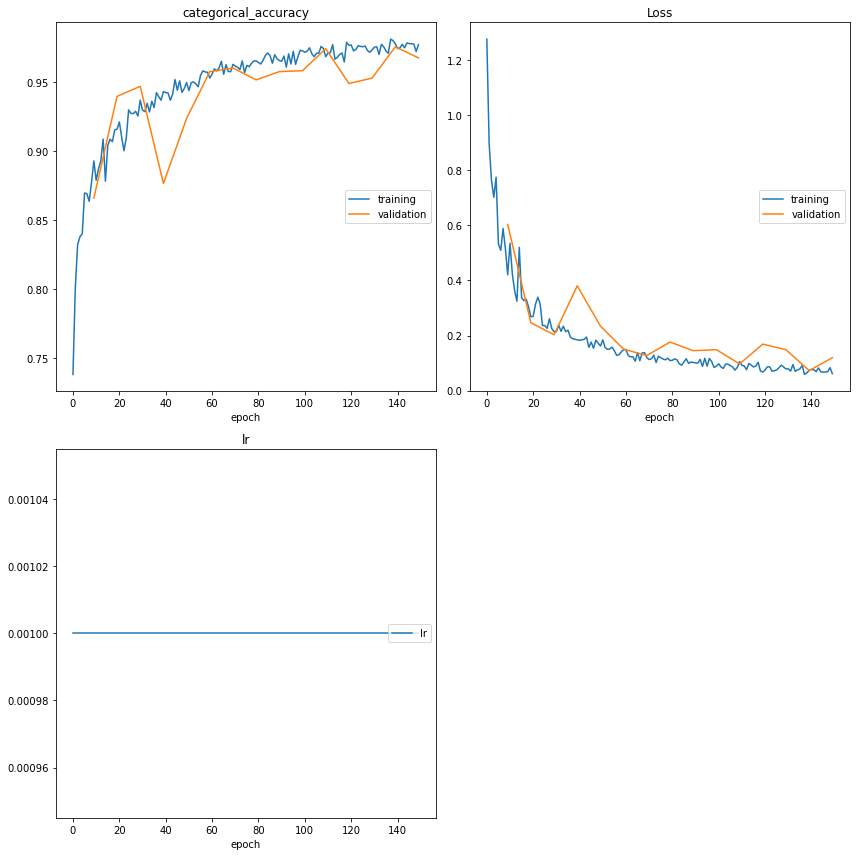

categorical_accuracy
	training         	 (min:    0.738, max:    0.981, cur:    0.977)
	validation       	 (min:    0.866, max:    0.975, cur:    0.967)
Loss
	training         	 (min:    0.059, max:    1.277, cur:    0.062)
	validation       	 (min:    0.073, max:    0.603, cur:    0.120)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
95/95 [==============================] - 5s 49ms/step - loss: 0.1195 - categorical_accuracy: 0.9674
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4700ms
Confusion Matrix
[[320   2   1   0   1   0   0   0   0   0  11   0]
 [  1  57   1   1   0   0   3   1   0   0   0   0]
 [  0  10 131   0   0   0   3   0   0   0   0   1]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  0   0   1   1 541   0   1   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0  77   0   0   0   0   0]
 [  0   0   0   0   0   0   5  81   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   

In [4]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [5]:
pipeline.save_pipeline()

In [6]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1505 images belonging to 12 classes.
95/95 [==============================] - 5s 49ms/step - loss: 0.1195 - categorical_accuracy: 0.9674
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4251ms
Confusion Matrix
[[320   2   1   0   1   0   0   0   0   0  11   0]
 [  1  57   1   1   0   0   3   1   0   0   0   0]
 [  0  10 131   0   0   0   3   0   0   0   0   1]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  0   0   1   1 541   0   1   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0  77   0   0   0   0   0]
 [  0   0   0   0   0   0   5  81   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0]
 [  2   1   0   0   0   0   0   0   0   0 231   0]
 [  0   0   0   0   0   0   0   0   0   0   1   5]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.99      0.96      0.97 

In [7]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [8]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Processing image took 1890.5778322219849 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-rgb-first-normal/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 255 out of 255
Processing image took 4554.171375274658 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-rgb-first-normal/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 255 out of 255
Processing image took 4392.655597686768 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-rgb-first-normal/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 56 out of 56
Processing image took 870.4131090641022 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-rgb-first-normal/ns-adenoca-colon-lupos-15071-2019-20x-he-14.tiff
Processing region 567 out of 567
Processing image took 9997.723456859589 seconds
Saving file...
File saved to